# 3. [Vision][PyTorch] Training Speed & Accuracy Comparison (3)
    - replace attention layer with TTT layer from Vi-T model

## Import Libraries

In [ ]:
%pip install transformers pygwalker wandb

In [1]:
import os
os.chdir("./tmp/src")

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import ViTConfig, ViTModel, ViTFeatureExtractor
from transformers.modeling_outputs import BaseModelOutputWithPooling
from transformers.models.vit.modeling_vit import ViTEncoder, ViTLayer

from ttt.lm.pytorch import Block as TTTBlock, TTTCache, TTTConfig

from torchvision import transforms, datasets, utils

from os import path, rename, mkdir, listdir

from tqdm.notebook import tqdm
import pygwalker as pyg
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# WandB Initialization
#wandb.init(project="3_vision_pytorch_normal")  # WandB Initialization
wandb.init(project="3_vision_pytorch_ttt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research). Use `wandb login --relogin` to force relogin


### Check GPU Availability

In [4]:
!nvidia-smi

Sun Dec  1 06:47:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |  15554MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 5

if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1
print(f"INFO: Using device - {device}:{DEVICE_NUM}")

INFO: Using device - cuda:5


## Load DataSets

In [6]:
from typing import Callable, Optional

datasets.utils.tqdm = tqdm


class FoodImageDataset(datasets.ImageFolder):
    download_method = datasets.utils.download_and_extract_archive
    download_url = "https://www.kaggle.com/api/v1/datasets/download/trolukovich/food11-image-dataset"
    
    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "validation")
            else:
                root = path.join(root, "training")
        else:
            root = path.join(root, "evaluation")
        
        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "archive.zip")):
            cls.download_method(cls.download_url, download_root=root, extract_root=root, filename="archive.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

In [7]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (224, 224)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [8]:
#feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
#vit_converter = lambda img, lb: (feature_extractor(images=img, return_tensors="pt"), lb)

In [9]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


In [10]:
# Train Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006282fce5256e8LKX4Y0lawZmdQk67" style="height: auto">\n    <hea…

In [11]:
# Valid Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006282fce580c98QGTv93jxpRyVMAc1" style="height: auto">\n    <hea…

In [12]:
# Test Dataset Distribution
pyg.walk(train_dataset.df)

Box(children=(HTML(value='\n<div id="ifr-pyg-0006282fce5cfbf9eVUElLoiXd9x1Dws" style="height: auto">\n    <hea…

## Data Augmentation

In [13]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [14]:
augmenter = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [15]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [16]:
# Set Batch Size
BATCH_SIZE = 32

In [17]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


In [18]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


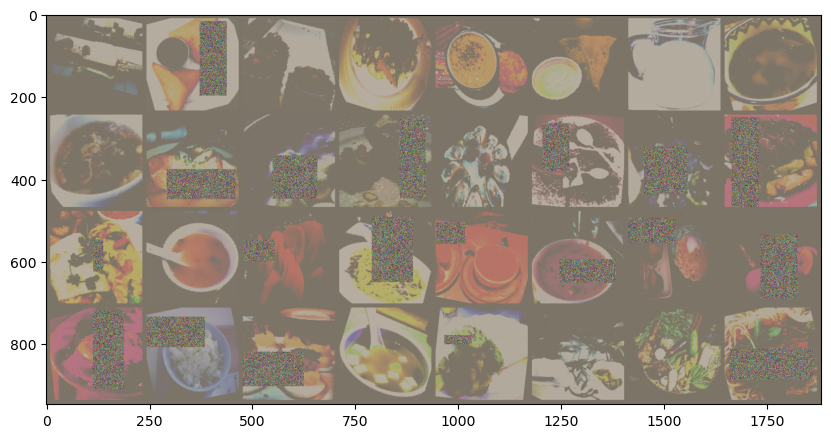

In [19]:
images, targets = next(iter(train_loader))
grid_images = utils.make_grid(images, nrow=8, padding=10)
imshow(grid_images)

## Define Model

### Model Configuration

In [18]:
common_config = dict(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    image_size=224,
    patch_size=16,
    num_channels=3,
    qkv_bias=True,
    encoder_stride=16
)

### Normal Vi-T

In [ ]:
class ViTImageClassifier(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = ViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [ ]:
# Initialize Model
model = ViTImageClassifier(config=ViTConfig(**common_config), num_classes=len(train_dataset.classes))
model.to(device)

### TTT Vi-T

In [ ]:
from typing import Union, Tuple


class TTTViTLayer(ViTLayer):
    def __init__(self, config: ViTConfig, ttt_config: TTTConfig, layer_idx: int):
        super().__init__(config)
        self.ttt_config = ttt_config
        self.layer_idx = layer_idx
        self.attention = TTTBlock(config=ttt_config, layer_idx=layer_idx)

    def forward(
            self,
            hidden_states: torch.Tensor,
            head_mask: Optional[torch.Tensor] = None,
            output_attentions: bool = False
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states)  # in ViT, layernorm is applied before self-attention
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + tuple(outputs.tolist())

        return outputs

In [ ]:
class TTTViTEncoder(ViTEncoder):
    def __init__(self, config: ViTConfig, ttt_config: TTTConfig):
        super().__init__(config)
        self.ttt_config = ttt_config
        self.layer = nn.ModuleList([TTTBlock(ttt_config, layer_idx) for layer_idx in range(config.num_hidden_layers)])

    def forward(
            self,
            hidden_states: torch.Tensor,
            head_mask: Optional[torch.Tensor] = None,
            output_attentions: bool = False,
            output_hidden_states: bool = False,
            return_dict: bool = True,
    ) -> Union[tuple, BaseModelOutput]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    layer_head_mask,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions
        )

In [ ]:
class TTTViTImageClassifier(nn.Module):
    def __init__(self, config: ViTConfig, ttt_config: TTTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.ttt_config = ttt_config
        self.vit = ViTModel(config=config)
        self.vit.encoder = TTTViTEncoder(config=config, ttt_config=ttt_config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [ ]:
# Initialize Model
model = TTTViTImageClassifier(
    config=ViTConfig(**common_config),
    ttt_config=TTTConfig(**common_config),
    num_classes=len(train_dataset.classes)
)
model.to(device)

In [ ]:
ttt_config = dict(
    ttt_layer_type="linear",  # or "mlp"
    ttt_base_lr=1.0,
    mini_batch_size=16,
    pre_conv=False
)

In [ ]:
class TTTViTConfig(ViTConfig, TTTConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

In [ ]:
from typing import Optional, Union
from transformers.modeling_outputs import BaseModelOutput


class TTTViTEncoder(ViTEncoder):
    def __init__(self, config: TTTViTConfig) -> None:
        super().__init__(config=config)
        del self.layer  # Remove ViT Layer
        self.layers = nn.ModuleList([TTTBlock(config, layer_idx=idx) for idx in range(config.num_hidden_layers)])

    def forward(
            self,
            hidden_states: torch.Tensor,
            head_mask: Optional[torch.Tensor] = None,
            output_attentions: bool = False,
            output_hidden_states: bool = False,
            return_dict: bool = True,
    ) -> Union[tuple, BaseModelOutput]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layers):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    layer_head_mask,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

In [ ]:
class TTTViTModel(ViTModel):
    def __init__(self, config: TTTViTConfig):
        super().__init__(config)
        self.encoder = TTTViTEncoder(config)

    def forward(
            self,
            pixel_values=None,
            bool_masked_pos=None,
            head_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            interpolate_pos_encoding=None,
            return_dict=None,
            cache_params=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        # Initialize cache_params if needed
        if cache_params is None and self.training:
            cache_params = TTTCache(self.encoder, pixel_values.size(0))

        embedding_output = self.embeddings(
            pixel_values, bool_masked_pos=bool_masked_pos, interpolate_pos_encoding=interpolate_pos_encoding
        )

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            cache_params=cache_params,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)

        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
            return head_outputs + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [ ]:
class TTTViTImageClassifier(nn.Module):
    def __init__(self, config: TTTViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = TTTViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [ ]:
# Initialize Model
model = TTTViTImageClassifier(
    config=TTTViTConfig(**common_config, **ttt_config),
    num_classes=len(train_dataset.classes)
)
model.to(device)

In [19]:
class TTTViTConfig(ViTConfig, TTTConfig):
    def __init__(
            self,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.0,
            attention_probs_dropout_prob=0.0,
            initializer_range=0.02,
            layer_norm_eps=1e-12,
            image_size=224,
            patch_size=16,
            num_channels=3,
            qkv_bias=True,
            encoder_stride=16,
            # TTT specific configs
            use_gate=False,
            share_qk=False,
            ttt_layer_type="linear",
            ttt_base_lr=1.0,
            mini_batch_size=16,
            pre_conv=False,
            conv_kernel=4,
            scan_checkpoint_group_size=0,
            use_rope=False,  # option to control whether to use rotary embeddings
            **kwargs,
    ):
        super(ViTConfig, self).__init__(
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            hidden_act=hidden_act,
            hidden_dropout_prob=hidden_dropout_prob,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            initializer_range=initializer_range,
            layer_norm_eps=layer_norm_eps,
            image_size=image_size,
            patch_size=patch_size,
            num_channels=num_channels,
            qkv_bias=qkv_bias,
            encoder_stride=encoder_stride,
            **kwargs
        )

        super(TTTConfig, self).__init__(
            vocab_size=None,  # Not used in ViT
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            num_hidden_layers=num_hidden_layers,
            num_attention_heads=num_attention_heads,
            hidden_act=hidden_act,
            max_position_embeddings=None,  # Not used in ViT
            initializer_range=initializer_range,
            rms_norm_eps=layer_norm_eps,
            use_gate=use_gate,
            share_qk=share_qk,
            ttt_layer_type=ttt_layer_type,
            ttt_base_lr=ttt_base_lr,
            mini_batch_size=mini_batch_size,
            pre_conv=pre_conv,
            conv_kernel=conv_kernel,
            scan_checkpoint_group_size=scan_checkpoint_group_size
        )

        self.use_rope = use_rope

In [20]:
class TTTViTEncoder(ViTEncoder):
    def __init__(self, config: TTTViTConfig):
        super().__init__(config)
        self.config = config
        self.layer = nn.ModuleList([TTTBlock(config, layer_idx=i) for i in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
            self,
            hidden_states,
            cache_params: Optional[TTTCache] = None,
            head_mask: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = False,
            output_hidden_states: Optional[bool] = False,
            return_dict: Optional[bool] = True,
    ):
        all_hidden_states = () if output_hidden_states else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    layer_head_mask,
                    None,  # position_ids not used in TTT
                    cache_params,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=None,  # Not used in TTT
                    position_ids=None,  # Not used in TTT
                    cache_params=cache_params,
                )

            hidden_states = layer_outputs

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states] if v is not None)

        return BaseModelOutputWithPooling(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=None,  # TTT doesn't output attention weights
        )

In [21]:
class TTTViTModel(ViTModel):
    config_class = TTTViTConfig

    def __init__(self, config: TTTViTConfig):
        super().__init__(config)
        self.config = config

        self.embeddings = self.embeddings  # Reuse ViT embeddings
        self.encoder = TTTViTEncoder(config)
        self.layernorm = self.layernorm  # Reuse ViT final layernorm
        self.pooler = self.pooler  # Reuse ViT pooler

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
            self,
            pixel_values: Optional[torch.Tensor] = None,
            cache_params: Optional[TTTCache] = None,
            head_mask: Optional[torch.Tensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> BaseModelOutputWithPooling:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            embedding_output,
            cache_params=cache_params,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
            return head_outputs + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [22]:
from collections import defaultdict
from logging import getLogger

logger = getLogger(__name__)


class TTTViTCache(TTTCache):
    """Modified TTTCache for ViT architecture"""
    def __init__(self, model, batch_size: int):
        config = model.config
        self.seqlen_offset = 0
        self.mini_batch_size = config.mini_batch_size

        self.ttt_params_dict = defaultdict(dict)
        if "linear" in config.ttt_layer_type:
            self.ttt_param_names = ["W1", "b1"]
        elif "mlp" in config.ttt_layer_type:
            self.ttt_param_names = ["W1", "b1", "W2", "b2"]
        else:
            raise ValueError(f"TTT Layer Type {config.ttt_layer_type} not supported yet")

        self.conv_states_dic = defaultdict(dict)
        logger.info(f"Creating cache of size: {batch_size}")

        # Use encoder.layer instead of layers
        layers = model.encoder.layer
        for layer_idx in range(len(layers)):
            for name in self.ttt_param_names:
                weight = getattr(layers[layer_idx].seq_modeling_block, name)
                # Detach the weight to avoid in-place modifications affecting gradients
                tiled_weight = torch.tile(weight.unsqueeze(0), (batch_size,) + (1,) * weight.dim()).to(model.device)
                self.ttt_params_dict[f"{name}_states"][layer_idx] = tiled_weight.detach().clone()
                self.ttt_params_dict[f"{name}_grad"][layer_idx] = torch.zeros_like(tiled_weight)

            if config.pre_conv:
                self.conv_states_dic["pre_conv"][layer_idx] = torch.zeros(
                    batch_size,
                    config.hidden_size,
                    config.conv_kernel,
                    device=model.device,
                )
            if config.share_qk:
                self.conv_states_dic["ttt_conv_q"][layer_idx] = torch.zeros(
                    batch_size,
                    config.hidden_size,
                    config.conv_kernel,
                    device=model.device,
                )
                self.conv_states_dic["ttt_conv_k"][layer_idx] = torch.zeros(
                    batch_size,
                    config.hidden_size,
                    config.conv_kernel,
                    device=model.device,
                )

    def update(self, py_tree, layer_idx, seq_len):
        if seq_len % self.mini_batch_size == 0:
            # Create new tensors instead of modifying in-place
            for name in self.ttt_param_names:
                self.ttt_params_dict[f"{name}_states"][layer_idx] = py_tree[f"{name}_states"].detach().clone()
                self.ttt_params_dict[f"{name}_grad"][layer_idx] = torch.zeros_like(py_tree[f"{name}_states"])
        elif seq_len < self.mini_batch_size:
            if seq_len != 1 and self.seqlen_offset > 0 and self.seqlen_offset % self.mini_batch_size != 0:
                raise ValueError("fractional update not supported yet.")
            if (seq_len + self.seqlen_offset) % self.mini_batch_size == 0:
                for name in self.ttt_param_names:
                    self.ttt_params_dict[f"{name}_states"][layer_idx] = py_tree[f"{name}_states"].detach().clone()
                    self.ttt_params_dict[f"{name}_grad"][layer_idx] = torch.zeros_like(py_tree[f"{name}_states"])
            else:
                for name in self.ttt_param_names:
                    self.ttt_params_dict[f"{name}_grad"][layer_idx] = py_tree[f"{name}_grad"].detach().clone()
        else:
            raise ValueError(f"seq_len {seq_len} is a partial update not supported yet")

    def ttt_params_to_dict(self, layer_idx):
        return {
            name: self.ttt_params_dict[name][layer_idx].detach().clone()
            for name in self.ttt_params_dict
        }

In [23]:
class TTTViTImageClassifier(nn.Module):
    def __init__(self, config: TTTViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = TTTViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)
        self.cache_params = None

    def forward(self, x):
        batch_size = x.shape[0]

        # Initialize cache_params if not exists or batch size changed
        if self.cache_params is None or self.cache_params.ttt_params_dict["W1_states"][0].shape[0] != batch_size:
            self.cache_params = TTTViTCache(self.vit, batch_size)

        out = self.vit(
            pixel_values=x,
            cache_params=self.cache_params
        )
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [24]:
# Initialize Model
model = TTTViTImageClassifier(
    config=TTTViTConfig(
        ttt_base_lr=0.01,    # TTT learning rate
        use_gate=True        # Enable gating mechanism
    ),
    num_classes=len(train_dataset.classes)
)
model.to(device)

TTTViTImageClassifier(
  (vit): TTTViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TTTViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (seq_modeling_block): TTTLinear(
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (o_proj): Linear(in_features=768, out_features=768, bias=False)
            (post_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          )
          (mlp): SwiGluMLP(
            (gate_proj): Linear(in_features=768, out_features=3072, bias=False)
            (up_proj): Linear(in_features=768, out_features=3072, bias=False)
            (down_proj): Linea

In [20]:
class ImagePatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        image_size = config.image_size
        patch_size = config.patch_size
        num_channels = config.num_channels
        hidden_size = config.hidden_size

        self.num_patches = (image_size // patch_size) ** 2
        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

In [21]:
from dataclasses import dataclass
from transformers.utils import ModelOutput
from typing import Tuple


@dataclass
class VisionModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None

In [22]:
class TTTViTConfig(TTTConfig):
    def __init__(
            self,
            image_size=224,
            patch_size=16,
            num_channels=3,
            num_classes=1000,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_classes = num_classes

In [23]:
from ttt.lm.pytorch import TTTPreTrainedModel, RMSNorm


class TTTViTModel(TTTPreTrainedModel):
    def __init__(self, config: TTTViTConfig):
        super().__init__(config)
        self.num_classes = config.num_classes
        self.hidden_size = config.hidden_size

        # Image patch embedding
        self.patch_embed = ImagePatchEmbedding(config)

        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        # Position embedding
        num_positions = self.patch_embed.num_patches + 1  # +1 for [CLS] token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_positions, config.hidden_size))

        # TTT layers - reuse from original TTTModel
        self.layers = nn.ModuleList([TTTBlock(config, layer_idx) for layer_idx in range(config.num_hidden_layers)])

        # Layer norm
        self.norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        # Classification head
        self.head = nn.Linear(config.hidden_size, config.num_classes) if config.num_classes > 0 else nn.Identity()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
            self,
            pixel_values: torch.FloatTensor,
            labels: Optional[torch.LongTensor] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
            use_cache: Optional[bool] = None,
    ):
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get patch embeddings
        batch_size = pixel_values.shape[0]
        x = self.patch_embed.projection(pixel_values).flatten(2).transpose(1, 2)

        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embeddings
        x = x + self.pos_embed

        # Process through TTT layers
        all_hidden_states = () if output_hidden_states else None

        for layer in self.layers:
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (x,)

            x = layer(x)

        x = self.norm(x)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (x,)

        # Use [CLS] token for classification
        logits = self.head(x[:, 0])

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + (all_hidden_states,) if output_hidden_states else (logits,)
            return ((loss,) + output) if loss is not None else output

        return VisionModelOutput(
            loss=loss,
            logits=logits,
            hidden_states=all_hidden_states if output_hidden_states else None,
        )

In [24]:
class TTTViTImageClassifier(nn.Module):
    def __init__(self, config: TTTViTConfig):
        super().__init__()
        self.config = config
        self.vit = TTTViTModel(config=config)

    def forward(self, x):
        out = self.vit(x)
        return out

In [31]:
# Initialize Model
model = TTTViTImageClassifier(
    config=TTTViTConfig(
        image_size=224,
        patch_size=16,
        num_channels=3,
        num_classes=len(train_dataset.classes),
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        ttt_base_lr=0.0001,    # TTT learning rate
        use_gate=True        # Enable gating mechanism
    )
)
model.to(device)

TTTViTImageClassifier(
  (vit): TTTViTModel(
    (patch_embed): ImagePatchEmbedding(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x Block(
        (seq_modeling_block): TTTLinear(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (g_proj): Linear(in_features=768, out_features=768, bias=False)
          (post_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        )
        (mlp): SwiGluMLP(
          (gate_proj): Linear(in_features=768, out_features=3072, bias=False)
          (up_proj): Linear(in_features=768, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=768, bias=False)
          (act_fn): SiLU()


## Training Loop

In [32]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [33]:
# Jit Compile
import torch._dynamo
torch._dynamo.config.suppress_errors = True

if DEVICE_NUM != -1:
    capability = torch.cuda.get_device_capability(device)  # CUDA capability check
    major, minor = capability
    backend = "cudagraphs" if major <= 6 else "inductor"  # choose backend
    #model = torch.compile(model, backend=backend)
    print(f"CUDA Capability {major}.{minor} detected, using '{backend}'")

CUDA Capability 6.0 detected, using 'cudagraphs'


In [34]:
# Set Epoch Count & Learning Rate
EPOCHS = 100
LEARNING_RATE = 0.00001

criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [ ]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss = 0, 0

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).logits

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() / train_length
            corrects = (torch.max(outputs, 1)[1] == targets.data).sum()
            train_acc += corrects / len(train_dataset)

            update(loss)
            train_progress.update(1)
            if i != train_length-1: wandb.log({'Acc': corrects/len(inputs)*100, 'Loss': loss.item()})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:3}/{train_length}], Acc: {corrects/len(inputs):.6%}, Loss: {loss.item():.6f}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}", end="")
        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).logits

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        wandb.log({'Train Acc': train_acc*100, 'Train Loss': train_loss, 'Val Acc': val_acc*100, 'Val Loss': val_loss})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

Running Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/309 [00:00<?, ?it/s]

Validation:   0%|          | 0/108 [00:00<?, ?it/s]

Output()

Epoch [ 5/100], Step [309/309], Acc: 14.413112%, Loss: 2.340650, Valid Acc: 14.577258%, Valid Loss: 2.309038
Epoch [ 6/100], Step [ 28/309], Acc: 9.375000%, Loss: 2.4680976

In [ ]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"normal_vit_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model_id = "normal_vit_model"

model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")